# Computer Vision  💻 🤓

This notebook contains some implementations of Computer Vision/Image processing algorithms.

### Grayscale resolution

In [3]:
import sys
import math

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from __future__ import print_function
from ipywidgets import interact
import ipywidgets as widgets

def threshold(res):
  img = np.asarray(Image.open('images/lena.png').convert('L')).copy()
  step = math.ceil(255/res)
  regions = [(x, x+step, x+step-1) for x in range(0,255,step)]

  for (lo, hi, color) in regions:
    img[np.logical_and(img>=lo, img<hi)] = color
    
  plt.imshow(img, cmap='gray')
  plt.show()

_ = interact(threshold, res=widgets.IntSlider(min=2,max=16,step=1,value=4))

interactive(children=(IntSlider(value=4, description='res', max=16, min=2), Output()), _dom_classes=('widget-interact',))

### Variance based thresholding (Otsu, 1979)

Assume image has a grayscale resolution of $L$ gray levels.

The number of pixels with gray level $i$ is written as $n_{i}$, so the total number of pixels in the image is $N = n_{1} + n_{2} + \ldots + n_{L}$. Thus, the probability of a pixel having gray level $i$ is:

\begin{equation}
    p_{i}=\frac{n_{i}}{N}
\end{equation}
where

\begin{equation}
    p_{i}>=0 \qquad \sum_{i=1}^{L} p_{i}=1
\end{equation}

Compute between-class variance $\sigma_{B}^2$ and total variance $\sigma_{T}^2$ using $k$:

\begin{equation}
    \sigma_{B}^2=\pi_{0}(\mu_{0} - \mu_{T})^2 + \pi_{1}(\mu_{1} - \mu_{T})^2
\end{equation}

\begin{equation}
    \sigma_{T}^2=\sum_{i=1}^{L}(i - \mu_{T})^2p_{i}
\end{equation}
where

\begin{equation}
    \pi_{0}=\sum_{i=1}^{k}p_{i} \qquad \pi_{1}=\sum_{i=k+1}^{L}p_{i}=1-{\pi_{0}}
\end{equation}

\begin{equation}
    \mu_{0}=\sum_{i=1}^{k}ip_{i}/\pi_{0} \quad \mu_{1}=\sum_{i=k+1}^{L}ip_{i}/\pi_{1} \quad
    \mu_{T}=\sum_{i=1}^{L}ip_{i}
\end{equation}

The formula for the between-class variance can be simplified to:

\begin{equation}
    \sigma_{B}^2=\pi_{0}\pi_{1}(\mu_{1} - \mu_{0})^2
\end{equation}

For a single threshold, the criterion to be maximized is the ratio of the between-class variance to the total variance:

\begin{equation}
    \eta=\frac{\sigma_{B}^2}{\sigma_{T}^2}
\end{equation}


Taken from Computer and Machine Vision (Fourth Edition): Theory, Algorithms, Practicalities. E.R. Davies.

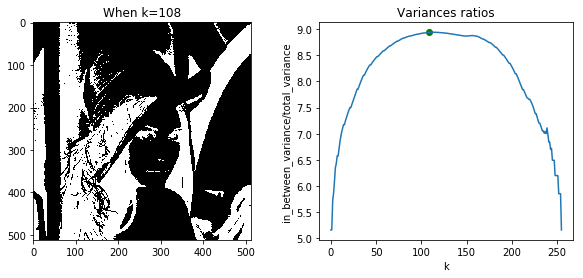

In [83]:
import sys

import numpy as np
from PIL import Image

image = np.asarray(Image.open('images/lena.png').convert('L'))
img = image.copy()
hist, _ = np.histogram(img, bins=256)

def histogram_variance(hist, k):
    probs = hist / hist.sum()

    pi_zero = np.sum(probs[:k])
    pi_one  = 1 - pi_zero

    def compute_mi_zero():
      factors = np.array(range(0,k)) / pi_zero
      return np.dot(probs[:k], factors)

    def compute_mi_one():
      factors = np.array(range(k+1, probs.size+1)) / pi_one
      return np.dot(probs[k:], factors)

    def compute_mi_t():
      factors = np.array(range(0, probs.size))
      return np.dot(probs, factors)

    mi_zero = compute_mi_zero()
    mi_one  = compute_mi_one()
    mi_t    = compute_mi_t()

    variance_b = pi_zero * pi_one * (mi_one - mi_zero) ** 2

    def compute_variance_t():
      factors = (np.array(range(0, probs.size)) - mi_t) ** 2
      return np.dot(probs, factors)

    variance_t = compute_variance_t()

    variances_ratio = variance_b / variance_t

    return variances_ratio

def variance_based_thresholding(hist):
    ratios = np.array([histogram_variance(hist, x) for x in range(0,256)])
    return np.argmax(ratios), ratios

k, ratios = variance_based_thresholding(hist)

black_region = np.where(img >= k)
white_region = np.where(img < k)

img[black_region] = 0
img[white_region] = 255

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.set_title(f'When k={k}')
ax1.imshow(img, cmap='gray')
plt.plot(k, entropies[k], 'go')
ax2.plot(entropies)

ax2.set_title('Variances ratios')
ax2.set_xlabel(f'k')
_ = ax2.set_ylabel('in_between_variance/total_variance')

### Entropy based thresholding (Kapur et al., 1985)

Divide intensity probability distribution in two classes: those with gray levels up to the threshold value $k$ and those with gray levels above $k$. This leads to two probability distributions A and B:

\begin{equation}
    A: \frac{p_{1}}{P_{k}}, \frac{p_{2}}{P_{k}}, \ldots, \frac{p_{k}}{P_{k}}
\end{equation}

\begin{equation}
    B: \frac{p_{k+1}}{1-p_{k}}, \frac{p_{k+2}}{1-p_{k}}, \ldots, \frac{p_{L}}{1-p_{k}}
\end{equation}

where:

\begin{equation}
    P_{k}=\sum_{i=1}^{k}p_{i} \qquad 1-p_{k}=\sum_{i=k+1}^{L}p_{i}
\end{equation}

\begin{equation}
    H(A)=-\sum_{i=1}^{k}\frac{p_{i}}{P_{k}}\ln{\frac{p_{i}}{P_{k}}}
\end{equation}

\begin{equation}
    H(B)=-\sum_{i=k+1}^{L}\frac{p_{i}}{1-P_{k}}\ln{\frac{p_{i}}{1-P_{k}}}
\end{equation}

and the total entropy is:

\begin{equation}
    H(k) = H(A) + H(B)
\end{equation}


Taken from Computer and Machine Vision (Fourth Edition): Theory, Algorithms, Practicalities. E.R. Davies.

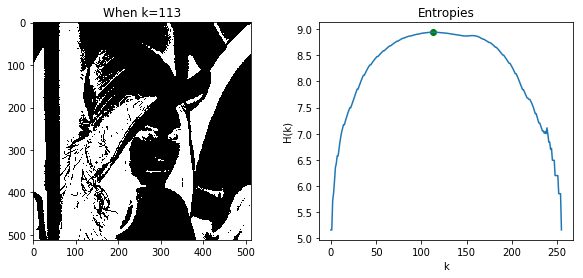

In [85]:
import sys
import math

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = np.asarray(Image.open('images/lena.png').convert('L'))
img = image.copy()
hist, _ = np.histogram(img, bins=256)

def histogram_entropy(hist, k):
    probs = hist / hist.sum()
    pk = np.sum(probs[:k])
    pk_complement = 1 - pk

    a_dist = probs[:k] / pk
    b_dist = probs[k:] / pk_complement

    def dist_entropy(dist):
        def entropy(x):
            if x > 0:
                return -x * math.log(x)
            else:
                return 0
        entropy_v = np.vectorize(entropy, otypes=[np.dtype('f8')])
        return np.sum(entropy_v(dist))

    entropy_a = dist_entropy(a_dist)
    entropy_b = dist_entropy(b_dist)

    total_entropy = entropy_a + entropy_b

    return total_entropy

def maximum_entropy_thresholding(hist):
    entropies = np.array([histogram_entropy(hist, x) for x in range(0,256)])
    return np.argmax(entropies), entropies

k, entropies = maximum_entropy_thresholding(hist)

black_region = np.where(img >= k)
white_region = np.where(img < k)

img[black_region] = 0
img[white_region] = 255

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)
ax1.set_title(f'When k={k}')
ax1.imshow(img, cmap='gray')
plt.plot(k, entropies[k], 'go')
ax2.plot(entropies)

ax2.set_title('Entropies')
ax2.set_xlabel(f'k')
_ = ax2.set_ylabel('H(k)')

### Line Hough transform

In [4]:
import sys
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact
import ipywidgets as widgets

def hough_transform(canny_abajo, canny_arriba, umbral_lineas):
  image_color = cv2.imread("images/cuadrado.png")
  image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
  
  bordes = cv2.Canny(image, canny_abajo, canny_arriba)
  
  (w,h) = image.shape
  diagonal = math.ceil(math.sqrt(w ** 2 + h** 2))
  espacio_p = np.zeros((diagonal, 181))

  for i in range(w):
    for j in range(h):
      if bordes[i][j] != 0:
        for t in range(-90, 90+1):
          p = (i * math.cos(t)) + (j * math.sin(t))
          espacio_p[math.floor(p)][t+90] += 1

  lineas = np.argwhere(espacio_p > umbral_lineas)
  
  for (p,theta) in lineas:
    a = math.sin(theta-90)
    b = math.cos(theta-90)
    x = a*p
    y = b*p
    p1 = (math.floor(x+1000*(-b)), math.floor(y+1000*a))
    p2 = (math.floor(x-1000*(-b)), math.floor(y-1000*a))
    cv2.line(image_color, p1, p2, (0,255,0))
    
  plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
  plt.show()

    
_ = interact(
    hough_transform,
    canny_abajo=widgets.IntSlider(min=0,max=255,step=1,value=100),
    canny_arriba=widgets.IntSlider(min=0,max=255,step=1,value=200),
    umbral_lineas=widgets.IntSlider(min=0,max=255,step=1,value=70)
)

interactive(children=(IntSlider(value=100, description='canny_abajo', max=255), IntSlider(value=200, description='canny_arriba', max=255), IntSlider(value=70, description='umbral_lineas', max=255), Output()), _dom_classes=('widget-interact',))

### Circle Hough transform

In [2]:
import sys
import math

import cv2
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact
import ipywidgets as widgets

def circle_hough_transform(canny_abajo, canny_arriba, umbral_circulos, radio_estimado):
  image_color = cv2.imread("images/circulos.jpg")
  image = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
  
  bordes = cv2.Canny(image, canny_abajo, canny_arriba)

  (w, h) = image.shape
  espacio_p = np.zeros((w+1,h+1))

  for i in range(w):
    for j in range(h):
      if bordes[i][j] != 0:
        for t in range(0, 360+1):
          a= i - (radio_estimado*math.cos(t))
          b= j - (radio_estimado*math.sin(t))
          if (a>=0 and b>=0 and a<=w-1 and b<=h-1):
            espacio_p[math.floor(a), math.floor(b)] += 1

  circulo_centros = np.argwhere(espacio_p > umbral_circulos)

  for centro in circulo_centros:
    cv2.circle(image_color, tuple(reversed(centro)), radio_estimado, (0,160,277))
             
  plt.imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
  plt.show()

_ = interact(
    circle_hough_transform,
    canny_abajo=widgets.IntSlider(min=0, max=255, step=1, value=100),
    canny_arriba=widgets.IntSlider(min=0, max=255, step=1, value=200),
    umbral_circulos=widgets.IntSlider(min=0, max=255, step=1, value=40),
    radio_estimado=widgets.IntSlider(min=0, max=255, step=1, value=100)
)                     

interactive(children=(IntSlider(value=100, description='canny_abajo', max=255), IntSlider(value=200, description='canny_arriba', max=255), IntSlider(value=40, description='umbral_circulos', max=255), IntSlider(value=100, description='radio_estimado', max=255), Output()), _dom_classes=('widget-interact',))

### Custom BFS-based segmentation algorithm

Note that this algorithm is very slow.

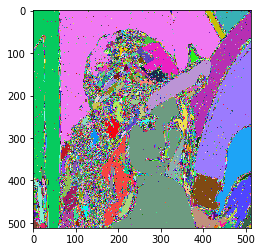

In [6]:
import sys
import queue
import random

import cv2
import numpy as np
import matplotlib.pyplot as plt

from __future__ import print_function
from ipywidgets import interact
import ipywidgets as widgets

class Explorador:
  def __init__(self, imagen, d):
    self.imagen = imagen
    self.d = d
    self.vecindario = 1
    self.vecindarios = np.zeros(imagen.shape, dtype=np.int64)
    self.w,self.h = self.imagen.shape
    self.cola = queue.Queue()

  def movimiento_valido(self, m, n):
    return m >= 0 and n >= 0 and m <= self.w - 1 and n <= self.h - 1

  def es_vecino(self, actual, siguiente):
    return siguiente <= actual + self.d and siguiente >= actual - self.d

  def explorado(self, m, n):
    return self.vecindarios[m, n] != 0

  def busqueda(self, m, n):
    self.vecindarios[m,n] = self.vecindario
    self.cola.put((m, n))

    while not self.cola.empty():
      x,y = self.cola.get()
      for direccion_x, direccion_y in [(1, 0),(-1, 0),(0, 1),(0, -1)]:
        movimiento_x = x + direccion_x 
        movimiento_y = y + direccion_y
        if self.movimiento_valido(movimiento_x, movimiento_y) and \
           (not self.explorado(movimiento_x, movimiento_y)) and \
           self.es_vecino(self.imagen[x,y], self.imagen[movimiento_x,movimiento_y]):
           self.vecindarios[movimiento_x,movimiento_y] = self.vecindario
           self.cola.put((movimiento_x,movimiento_y))

  def descubrir_vecindarios(self):
    for x in range(self.w):
      for y in range(self.h):
        if self.vecindarios[x,y] == 0: # 0 es no se ha visitado
          self.busqueda(x,y)
          self.vecindario+=1

    return self.vecindarios

def vecindarios_coloreados(imagen):
  color = lambda: (random.randint(0,255),random.randint(0,255),random.randint(0,255))
  w,h = imagen.shape
  coloreada = np.zeros((w,h,3), np.uint8)
  num_vecindarios = np.amax(imagen)
  for vecindario in range(num_vecindarios + 1):
    coloreada[np.where(imagen == (vecindario + 1))] = color()

  return coloreada

def descubrir_vecindarios(d):
  imagen = cv2.imread("images/lena.png", 0)
  e = Explorador(imagen, d)
  resultado = e.descubrir_vecindarios()
  plt.imshow(cv2.cvtColor(vecindarios_coloreados(resultado), cv2.COLOR_BGR2RGB))
  plt.show()

descubrir_vecindarios(3)